In [3]:
import zipfile
with zipfile.ZipFile("C:/Users/medici/Desktop/syrup/open.zip", "r") as zip_ref:
    zip_ref.extractall("C:/Users/medici/Desktop/syrup/datasets")

In [ ]:
# import numpy as np
# import random
# import torch

# # Python random seed
# random.seed(42)

# # NumPy seed
# np.random.seed(42)

# # PyTorch seed
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# torch.cuda.manual_seed_all(42)  # If you are using multi-GPU.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
import os
from scipy.stats import uniform

In [2]:
# 1. GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [16]:
item_configs = {'건고추': {'learning_rate': 0.01, 'epoch': 100, 'batch_size': 128, 'hidden_size': 128, 'num_layers': 4, 'dropout': 0.4}, 
                '사과': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 3, 'dropout': 0.2}, 
                '감자': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.3}, 
                '배': {'learning_rate': 0.01, 'epoch': 100, 'batch_size': 64, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.2}, 
                '깐마늘(국산)': {'learning_rate': 0.01, 'epoch': 100, 'batch_size': 32, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3}, 
                '무': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 64, 'hidden_size': 256, 'num_layers': 3, 'dropout': 0.3}, 
                '상추': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3}, 
                '배추': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.5}, 
                '양파': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 3, 'dropout': 0.2}, 
                '대파': {'learning_rate': 0.001, 'epoch': 100, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.5}}


# Function to get configuration for a specific item
def get_config_for_item(item_name):
    config = item_configs.get(item_name, item_configs["건고추"])  # Default to '건고추' config if item is missing
    config['output_size'] = 3
    return SimpleNamespace(**config)

# 품목 리스트
품목_리스트 = ["건고추", "사과", "감자", "배", "깐마늘(국산)", "무", "상추", "배추", "양파", "대파"]

# 각 품목에 대해 설정을 불러오고 모델을 학습 또는 평가
for item_name in 품목_리스트:
    CFG = get_config_for_item(item_name)  # 각 품목의 설정 불러오기
    print(f"현재 품목: {item_name}, 설정: {CFG}")
    
    # 데이터를 train과 validation으로 분할
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    
    # DataLoader 생성
    train_loader = DataLoader(train_data, CFG.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, CFG.batch_size, shuffle=False)

현재 품목: 건고추, 설정: namespace(learning_rate=0.01, epoch=100, batch_size=128, hidden_size=128, num_layers=4, dropout=0.4, output_size=3)
현재 품목: 사과, 설정: namespace(learning_rate=0.001, epoch=100, batch_size=32, hidden_size=128, num_layers=3, dropout=0.2, output_size=3)
현재 품목: 감자, 설정: namespace(learning_rate=0.001, epoch=100, batch_size=32, hidden_size=64, num_layers=3, dropout=0.3, output_size=3)
현재 품목: 배, 설정: namespace(learning_rate=0.01, epoch=100, batch_size=64, hidden_size=64, num_layers=3, dropout=0.2, output_size=3)
현재 품목: 깐마늘(국산), 설정: namespace(learning_rate=0.01, epoch=100, batch_size=32, hidden_size=64, num_layers=1, dropout=0.3, output_size=3)
현재 품목: 무, 설정: namespace(learning_rate=0.001, epoch=100, batch_size=64, hidden_size=256, num_layers=3, dropout=0.3, output_size=3)
현재 품목: 상추, 설정: namespace(learning_rate=0.001, epoch=100, batch_size=32, hidden_size=128, num_layers=1, dropout=0.3, output_size=3)
현재 품목: 배추, 설정: namespace(learning_rate=0.001, epoch=100, batch_size=32, hidden_size=

In [4]:
def process_data(raw_file, 산지공판장_file, 전국도매_file, 품목명, scaler=None):
    raw_data = pd.read_csv(raw_file)
    산지공판장 = pd.read_csv(산지공판장_file)
    전국도매 = pd.read_csv(전국도매_file)

    # 타겟 및 메타데이터 필터 조건 정의
    conditions = {
    '감자': {
        'target': lambda df: (df['품종명'] == '감자 수미') & (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['감자'], '품종명': ['수미'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['감자'], '품종명': ['수미']}
    },
    '건고추': {
        'target': lambda df: (df['품종명'] == '화건') & (df['거래단위'] == '30 kg') & (df['등급'] == '상품'),
        '공판장': None,
        '도매': None
    },
    '깐마늘(국산)': {
        'target': lambda df: (df['거래단위'] == '20 kg') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['마늘'], '품종명': ['깐마늘'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['마늘'], '품종명': ['깐마늘']}
    },
    '대파': {
        'target': lambda df: (df['품종명'] == '대파(일반)') & (df['거래단위'] == '1키로단') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['대파'], '품종명': ['대파(일반)'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['대파'], '품종명': ['대파(일반)']}
    },
    '무': {
        'target': lambda df: (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['무'], '품종명': ['기타무'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['무'], '품종명': ['무']}
    },
    '배추': {
        'target': lambda df: (df['거래단위'] == '10키로망대') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배추'], '품종명': ['쌈배추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배추'], '품종명': ['배추']}
    },
    '사과': {
        'target': lambda df: (df['품종명'].isin(['홍로', '후지'])) & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['사과'], '품종명': ['후지'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['사과'], '품종명': ['후지']}
    },
    '상추': {
        'target': lambda df: (df['품종명'] == '청') & (df['거래단위'] == '100 g') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['상추'], '품종명': ['청상추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['상추'], '품종명': ['청상추']}
    },
    '양파': {
        'target': lambda df: (df['품종명'] == '양파') & (df['거래단위'] == '1키로') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['양파'], '품종명': ['기타양파'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['양파'], '품종명': ['양파(일반)']}
    },
    '배': {
        'target': lambda df: (df['품종명'] == '신고') & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배'], '품종명': ['신고'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배'], '품종명': ['신고']}
    }
    }

    # 타겟 데이터 필터링
    raw_품목 = raw_data[raw_data['품목명'] == 품목명]
    target_mask = conditions[품목명]['target'](raw_품목)
    filtered_data = raw_품목[target_mask]

    # 다른 품종에 대한 파생변수 생성
    other_data = raw_품목[~target_mask]
    unique_combinations = other_data[['품종명', '거래단위', '등급']].drop_duplicates()
    for _, row in unique_combinations.iterrows():
        품종명, 거래단위, 등급 = row['품종명'], row['거래단위'], row['등급']
        mask = (other_data['품종명'] == 품종명) & (other_data['거래단위'] == 거래단위) & (other_data['등급'] == 등급)
        temp_df = other_data[mask]
        for col in ['평년 평균가격(원)', '평균가격(원)']:
            new_col_name = f'{품종명}_{거래단위}_{등급}_{col}'
            filtered_data = filtered_data.merge(temp_df[['시점', col]], on='시점', how='left', suffixes=('', f'_{new_col_name}'))
            filtered_data.rename(columns={f'{col}_{new_col_name}': new_col_name}, inplace=True)

    # 공판장 데이터 처리
    if conditions[품목명]['공판장']:
        filtered_공판장 = 산지공판장
        for key, value in conditions[품목명]['공판장'].items():
            filtered_공판장 = filtered_공판장[filtered_공판장[key].isin(value)]

        filtered_공판장 = filtered_공판장.add_prefix('공판장_').rename(columns={'공판장_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_공판장, on='시점', how='left')

    # 도매 데이터 처리
    if conditions[품목명]['도매']:
        filtered_도매 = 전국도매
        for key, value in conditions[품목명]['도매'].items():
            filtered_도매 = filtered_도매[filtered_도매[key].isin(value)]

        filtered_도매 = filtered_도매.add_prefix('도매_').rename(columns={'도매_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_도매, on='시점', how='left')


    ##################### 전처리 #####################

    # 시점 컬럼은 datetime 칼럼 타입으로 바꾸기
    # def convert_date(date_str):

    #     year_month = date_str[:6]
    #     if '상순' in date_str:
    #         day = '01'
    #     elif '중순' in date_str:
    #         day = '11'
    #     elif '하순' in date_str:
    #         day = '21'
    #     else:
    #         return None

    #     final_date_str = year_month + day
    #     return pd.to_datetime(final_date_str)
    # filtered_data["시점"] = filtered_data["시점"].apply(convert_date)

    # filtered_data["year"] = filtered_data["시점"].dt.year
    # filtered_data["month"] = filtered_data["시점"].dt.month
    # filtered_data['season'] = filtered_data['시점'].dt.month % 12 // 3 + 1  # 1:봄, 2:여름, 3:가을, 4:겨울

    # for col in filtered_data.columns:
    #     if "평균가격" in col and "평년" not in col and col != "평균가격(원)":

    #         # 극단적인 이상치만 평균값으로 대체
    #         for i in range(1, len(filtered_data)):
    #             if filtered_data.loc[i, col] == 0:
    #                 filtered_data.loc[i, col] = filtered_data.loc[i - 1, col]

    # 평균가격 값이 0인 것이 일정 수준 이하라면 그 칼럼을 제거한다.
    # drop_columns = []
    # for col in filtered_data.columns:
    #     zero_cols = len(filtered_data[filtered_data[col]==0])
    #     if zero_cols/len(filtered_data) > 0.5:
    #         drop_columns.append(col)

    # 평년 평균가 이상치 제거 - 가끔가다 0인게 있음

    #################################################


    # 수치형 컬럼 처리
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    filtered_data = filtered_data[['시점'] + list(numeric_columns)]
    filtered_data[numeric_columns] = filtered_data[numeric_columns].fillna(0)

    # 정규화 적용
    if scaler is None:
        scaler = MinMaxScaler()
        filtered_data[numeric_columns] = scaler.fit_transform(filtered_data[numeric_columns])
    else:
        filtered_data[numeric_columns] = scaler.transform(filtered_data[numeric_columns])

    return filtered_data, scaler

In [6]:
class AgriculturePriceDataset(Dataset):
    def __init__(self, dataframe, window_size=9, prediction_length=3, is_test=False):
        self.data = dataframe
        self.window_size = window_size
        self.prediction_length = prediction_length
        self.is_test = is_test

        self.price_column = '평균가격(원)'
        self.numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()

        self.sequences = []
        if not self.is_test:
            for i in range(len(self.data) - self.window_size - self.prediction_length + 1):
                x = self.data[self.numeric_columns].iloc[i:i+self.window_size].values
                y = self.data[self.price_column].iloc[i+self.window_size:i+self.window_size+self.prediction_length].values
                self.sequences.append((x, y))
        else:
            self.sequences = [self.data[self.numeric_columns].values]

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if not self.is_test:
            x, y = self.sequences[idx]
            return torch.FloatTensor(x), torch.FloatTensor(y)
        else:
            return torch.FloatTensor(self.sequences[idx])

In [7]:
class PricePredictionLSTMCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_filters=16, kernel_size=3):
        super(PricePredictionLSTMCNN, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size,
                               out_channels=num_filters,
                               kernel_size=4,
                               padding=1
                               )
        self.conv2 = nn.Conv1d(in_channels=num_filters,
                               out_channels=num_filters,
                               kernel_size=3,
                               padding=1
                               )
        self.conv3 = nn.Conv1d(in_channels=num_filters,
                               out_channels=num_filters,
                               kernel_size=2,
                               padding=1
                               )

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # LSTM layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(num_filters, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(layer.weight)  # 자비어 초기화
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)  # 바이어스는 0으로 초기화

    def forward(self, x):
        # CNN layers
        x = x.transpose(1, 2)  # Switch batch and channel for Conv1d
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.transpose(1, 2)  # Switch back to batch, seq, feature for LSTM

        # Initialize LSTM hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Fully connected layer
        out = self.fc(out[:, -1, :])
        return out


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    return total_loss / len(test_loader)

# EDA

In [9]:
품목명 = "사과"

train_data, scaler = process_data("C:/Users/medici/Desktop/syrup/train.csv",
                            "C:/Users/medici/Desktop/syrup/TRAIN_산지공판장_2018-2021.csv",
                            "C:/Users/medici/Desktop/syrup/TRAIN_전국도매_2018-2021.csv",
                            품목명)

import matplotlib.pyplot as plt

train_data.columns

Index(['시점', '평년 평균가격(원)', '평균가격(원)', '쓰가루_10 개_상품_평년 평균가격(원)',
       '쓰가루_10 개_상품_평균가격(원)', '쓰가루_10 개_중품_평년 평균가격(원)', '쓰가루_10 개_중품_평균가격(원)',
       '후지_10 개_중품_평년 평균가격(원)', '후지_10 개_중품_평균가격(원)', '홍로_10 개_중품_평년 평균가격(원)',
       '홍로_10 개_중품_평균가격(원)', '공판장_공판장코드', '공판장_품목코드', '공판장_품종코드', '공판장_등급코드',
       '공판장_총반입량(kg)', '공판장_총거래금액(원)', '공판장_평균가(원/kg)', '공판장_중간가(원/kg)',
       '공판장_최저가(원/kg)', '공판장_최고가(원/kg)', '공판장_경매 건수',
       '공판장_전순 평균가격(원) PreVious SOON', '공판장_전달 평균가격(원) PreVious MMonth',
       '공판장_전년 평균가격(원) PreVious YeaR', '공판장_평년 평균가격(원) Common Year SOON',
       '공판장_연도', '도매_시장코드', '도매_품목코드', '도매_품종코드', '도매_총반입량(kg)', '도매_총거래금액(원)',
       '도매_평균가(원/kg)', '도매_고가(20%) 평균가', '도매_중가(60%) 평균가 ', '도매_저가(20%) 평균가',
       '도매_중간가(원/kg)', '도매_최저가(원/kg)', '도매_최고가(원/kg)', '도매_경매 건수',
       '도매_전순 평균가격(원) PreVious SOON', '도매_전달 평균가격(원) PreVious MMonth',
       '도매_전년 평균가격(원) PreVious YeaR', '도매_평년 평균가격(원) Common Year SOON',
       '도매_연도'],
      dtype='object')

c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\medici\miniconda3\env

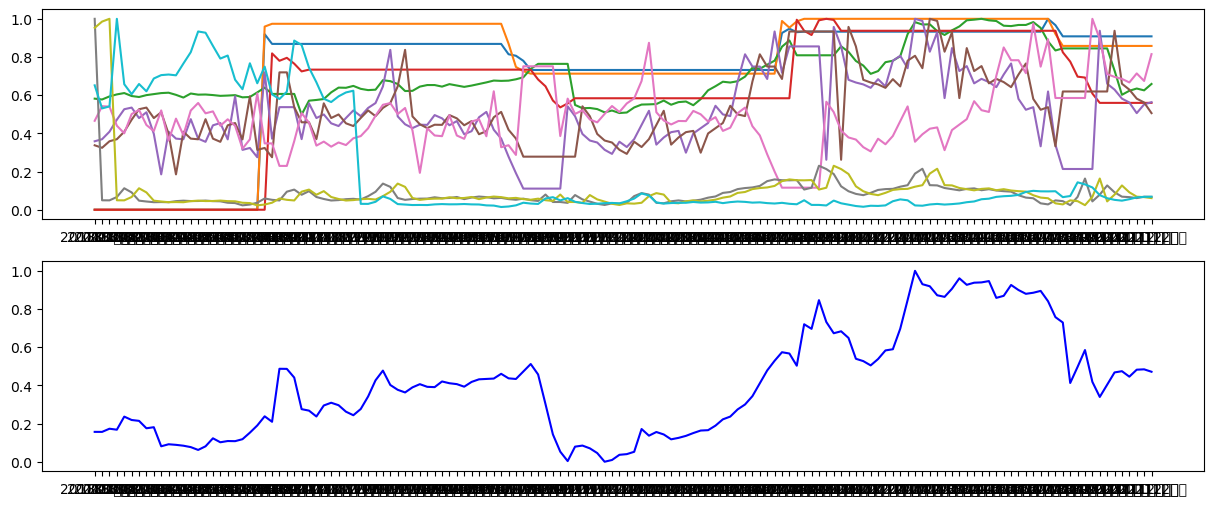

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 6))

for col in train_data.columns:
    if "평균가격" in col and "평년" not in col and col != "평균가격(원)":

        # 극단적인 이상치만 평균값으로 대체
        for i in range(1, len(train_data)):
            if train_data.loc[i, col] == 0:
                train_data.loc[i, col] = train_data.loc[i - 1, col]

        axs[0].plot(train_data["시점"], train_data[col], label=col)
axs[1].plot(train_data["시점"], train_data['평균가격(원)'], color="blue")

# train

In [12]:
품목별_predictions = {}
품목별_scalers = {}

import torch
import torch.nn as nn

class NMAELoss(nn.Module):
    def __init__(self):
        super(NMAELoss, self).__init__()

    def forward(self, y_pred, y_true):
        mae = torch.abs(y_pred - y_true).mean()
        # y_true의 평균을 기준으로 정규화
        nmae = mae / torch.mean(torch.abs(y_true))
        return nmae


pbar_outer = tqdm(['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파'], desc="품목 처리 중", position=0)
for 품목명 in pbar_outer:
    pbar_outer.set_description(f"품목별 전처리 및 모델 학습 -> {품목명}")
    train_data, scaler = process_data("C:/Users/medici/Desktop/syrup/train.csv",
                              "C:/Users/medici/Desktop/syrup/TRAIN_산지공판장_2018-2021.csv",
                              "C:/Users/medici/Desktop/syrup/TRAIN_전국도매_2018-2021.csv",
                              품목명)


    # ------------ 추가 전처리 ------------ #
    # drop_col = []
    # for col in train_data.columns:
    #     zeros = len(train_data[train_data[col]==0])
    #     if zeros/len(train_data) > 0.75:
    #         drop_col.append(col)
    # train_data = train_data.drop(columns=drop_col)
    # ----------------------------------- #


    품목별_scalers[품목명] = scaler
    dataset = AgriculturePriceDataset(train_data)

    # 데이터를 train과 validation으로 분할
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, CFG.batch_size, shuffle=True)
    val_loader = DataLoader(val_data, CFG.batch_size, shuffle=False)

    input_size = len(dataset.numeric_columns)

    model = PricePredictionLSTMCNN(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size)
    # criterion = nn.L1Loss()
    criterion = NMAELoss()
    optimizer = torch.optim.Adam(model.parameters(), CFG.learning_rate)

    best_val_loss = float('inf')
    os.makedirs('models', exist_ok=True)

    for epoch in range(CFG.epoch):
        train_loss = train_model(model, train_loader, criterion, optimizer, CFG.epoch)
        val_loss = evaluate_model(model, val_loader, criterion)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'models/best_model_{품목명}.pth')

        print(f'Epoch {epoch+1}/{CFG.epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Best Validation Loss for {품목명}: {best_val_loss:.4f}')

    품목_predictions = []

    ### 추론
    pbar_inner = tqdm(range(25), desc="테스트 파일 추론 중", position=1, leave=False)
    for i in pbar_inner:
        test_file = f"C:/Users/medici/Desktop/syrup/test/TEST_{i:02d}.csv"
        산지공판장_file = f"C:/Users/medici/Desktop/syrup/test/meta/TEST_산지공판장_{i:02d}.csv"
        전국도매_file = f"C:/Users/medici/Desktop/syrup/test/meta/TEST_전국도매_{i:02d}.csv"

        test_data, _ = process_data(test_file, 산지공판장_file, 전국도매_file, 품목명, scaler=품목별_scalers[품목명])

        # ------------ 추가 전처리 ------------ #

        # test_data = test_data.drop(columns=drop_col, axis=1)

        # ----------------------------------- #

        test_dataset = AgriculturePriceDataset(test_data, is_test=True)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                output = model(batch)
                predictions.append(output.numpy())

        predictions_array = np.concatenate(predictions)

        # 예측값을 원래 스케일로 복원
        price_column_index = test_data.columns.get_loc(test_dataset.price_column) - 1
        predictions_reshaped = predictions_array.reshape(-1, 1)

        # 가격 열에 대해서만 inverse_transform 적용
        price_scaler = MinMaxScaler()
        price_scaler.min_ = 품목별_scalers[품목명].min_[price_column_index]
        price_scaler.scale_ = 품목별_scalers[품목명].scale_[price_column_index]
        predictions_original_scale = price_scaler.inverse_transform(predictions_reshaped)


        if np.isnan(predictions_original_scale).any():
            pbar_inner.set_postfix({"상태": "NaN"})
        else:
            pbar_inner.set_postfix({"상태": "정상"})
            품목_predictions.extend(predictions_original_scale.flatten())


    품목별_predictions[품목명] = 품목_predictions
    pbar_outer.update(1)

품목 처리 중:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.1137, Val Loss: 0.9288
Epoch 2/100, Train Loss: 0.9393, Val Loss: 0.7537
Epoch 3/100, Train Loss: 0.7900, Val Loss: 0.5914
Epoch 4/100, Train Loss: 0.6543, Val Loss: 0.4746
Epoch 5/100, Train Loss: 0.5380, Val Loss: 0.7533
Epoch 6/100, Train Loss: 0.6434, Val Loss: 0.7716
Epoch 7/100, Train Loss: 0.6428, Val Loss: 0.6438
Epoch 8/100, Train Loss: 0.5998, Val Loss: 0.5690
Epoch 9/100, Train Loss: 0.5764, Val Loss: 0.5212
Epoch 10/100, Train Loss: 0.5719, Val Loss: 0.4741
Epoch 11/100, Train Loss: 0.5500, Val Loss: 0.4670
Epoch 12/100, Train Loss: 0.5480, Val Loss: 0.4758
Epoch 13/100, Train Loss: 0.5532, Val Loss: 0.4852
Epoch 14/100, Train Loss: 0.5584, Val Loss: 0.4934
Epoch 15/100, Train Loss: 0.5616, Val Loss: 0.4883
Epoch 16/100, Train Loss: 0.5557, Val Loss: 0.4706
Epoch 17/100, Train Loss: 0.5375, Val Loss: 0.4590
Epoch 18/100, Train Loss: 0.5301, Val Loss: 0.4606
Epoch 19/100, Train Loss: 0.5287, Val Loss: 0.4698
Epoch 20/100, Train Loss: 0.5332, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.9674, Val Loss: 0.7159
Epoch 2/100, Train Loss: 0.7850, Val Loss: 0.5548
Epoch 3/100, Train Loss: 0.6476, Val Loss: 0.4845
Epoch 4/100, Train Loss: 0.5518, Val Loss: 0.6942
Epoch 5/100, Train Loss: 0.5913, Val Loss: 0.7067
Epoch 6/100, Train Loss: 0.5984, Val Loss: 0.5991
Epoch 7/100, Train Loss: 0.5495, Val Loss: 0.5141
Epoch 8/100, Train Loss: 0.5360, Val Loss: 0.4855
Epoch 9/100, Train Loss: 0.5343, Val Loss: 0.4837
Epoch 10/100, Train Loss: 0.5478, Val Loss: 0.4835
Epoch 11/100, Train Loss: 0.5552, Val Loss: 0.4837
Epoch 12/100, Train Loss: 0.5540, Val Loss: 0.4837
Epoch 13/100, Train Loss: 0.5494, Val Loss: 0.4836
Epoch 14/100, Train Loss: 0.5403, Val Loss: 0.4865
Epoch 15/100, Train Loss: 0.5315, Val Loss: 0.4990
Epoch 16/100, Train Loss: 0.5347, Val Loss: 0.5192
Epoch 17/100, Train Loss: 0.5256, Val Loss: 0.5375
Epoch 18/100, Train Loss: 0.5312, Val Loss: 0.5464
Epoch 19/100, Train Loss: 0.5288, Val Loss: 0.5464
Epoch 20/100, Train Loss: 0.5358, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.9618, Val Loss: 0.6067
Epoch 2/100, Train Loss: 0.6406, Val Loss: 0.5383
Epoch 3/100, Train Loss: 0.6165, Val Loss: 0.6031
Epoch 4/100, Train Loss: 0.6617, Val Loss: 0.6100
Epoch 5/100, Train Loss: 0.6674, Val Loss: 0.5680
Epoch 6/100, Train Loss: 0.6384, Val Loss: 0.5432
Epoch 7/100, Train Loss: 0.6088, Val Loss: 0.5347
Epoch 8/100, Train Loss: 0.5903, Val Loss: 0.5424
Epoch 9/100, Train Loss: 0.5878, Val Loss: 0.5584
Epoch 10/100, Train Loss: 0.6034, Val Loss: 0.5701
Epoch 11/100, Train Loss: 0.6059, Val Loss: 0.5664
Epoch 12/100, Train Loss: 0.5998, Val Loss: 0.5535
Epoch 13/100, Train Loss: 0.5863, Val Loss: 0.5382
Epoch 14/100, Train Loss: 0.5735, Val Loss: 0.5251
Epoch 15/100, Train Loss: 0.5668, Val Loss: 0.5120
Epoch 16/100, Train Loss: 0.5541, Val Loss: 0.4993
Epoch 17/100, Train Loss: 0.5359, Val Loss: 0.4792
Epoch 18/100, Train Loss: 0.5287, Val Loss: 0.4593
Epoch 19/100, Train Loss: 0.4914, Val Loss: 0.4470
Epoch 20/100, Train Loss: 0.4700, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.9318, Val Loss: 0.6974
Epoch 2/100, Train Loss: 0.7285, Val Loss: 0.5530
Epoch 3/100, Train Loss: 0.5750, Val Loss: 0.5283
Epoch 4/100, Train Loss: 0.5196, Val Loss: 0.6190
Epoch 5/100, Train Loss: 0.5600, Val Loss: 0.6142
Epoch 6/100, Train Loss: 0.5615, Val Loss: 0.5587
Epoch 7/100, Train Loss: 0.5281, Val Loss: 0.5120
Epoch 8/100, Train Loss: 0.5079, Val Loss: 0.4940
Epoch 9/100, Train Loss: 0.5053, Val Loss: 0.4898
Epoch 10/100, Train Loss: 0.5088, Val Loss: 0.4893
Epoch 11/100, Train Loss: 0.5060, Val Loss: 0.4863
Epoch 12/100, Train Loss: 0.5071, Val Loss: 0.4796
Epoch 13/100, Train Loss: 0.4953, Val Loss: 0.4710
Epoch 14/100, Train Loss: 0.4853, Val Loss: 0.4641
Epoch 15/100, Train Loss: 0.4697, Val Loss: 0.4571
Epoch 16/100, Train Loss: 0.4482, Val Loss: 0.4510
Epoch 17/100, Train Loss: 0.4207, Val Loss: 0.4466
Epoch 18/100, Train Loss: 0.4191, Val Loss: 0.4194
Epoch 19/100, Train Loss: 0.3776, Val Loss: 0.3715
Epoch 20/100, Train Loss: 0.3078, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.8887, Val Loss: 0.7628
Epoch 2/100, Train Loss: 0.7900, Val Loss: 0.6634
Epoch 3/100, Train Loss: 0.7101, Val Loss: 0.5465
Epoch 4/100, Train Loss: 0.6039, Val Loss: 0.5243
Epoch 5/100, Train Loss: 0.5161, Val Loss: 0.8312
Epoch 6/100, Train Loss: 0.6397, Val Loss: 0.6867
Epoch 7/100, Train Loss: 0.5362, Val Loss: 0.5517
Epoch 8/100, Train Loss: 0.4979, Val Loss: 0.4882
Epoch 9/100, Train Loss: 0.5115, Val Loss: 0.4817
Epoch 10/100, Train Loss: 0.5227, Val Loss: 0.4783
Epoch 11/100, Train Loss: 0.5332, Val Loss: 0.4715
Epoch 12/100, Train Loss: 0.5263, Val Loss: 0.4627
Epoch 13/100, Train Loss: 0.5232, Val Loss: 0.4628
Epoch 14/100, Train Loss: 0.5039, Val Loss: 0.4816
Epoch 15/100, Train Loss: 0.4830, Val Loss: 0.5109
Epoch 16/100, Train Loss: 0.4778, Val Loss: 0.5413
Epoch 17/100, Train Loss: 0.4748, Val Loss: 0.5695
Epoch 18/100, Train Loss: 0.4648, Val Loss: 0.5776
Epoch 19/100, Train Loss: 0.4709, Val Loss: 0.5476
Epoch 20/100, Train Loss: 0.4461, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.1854, Val Loss: 0.8831
Epoch 2/100, Train Loss: 0.8947, Val Loss: 0.6300
Epoch 3/100, Train Loss: 0.6764, Val Loss: 0.5567
Epoch 4/100, Train Loss: 0.6236, Val Loss: 0.6171
Epoch 5/100, Train Loss: 0.6681, Val Loss: 0.6279
Epoch 6/100, Train Loss: 0.6614, Val Loss: 0.6135
Epoch 7/100, Train Loss: 0.6493, Val Loss: 0.5920
Epoch 8/100, Train Loss: 0.6366, Val Loss: 0.5757
Epoch 9/100, Train Loss: 0.6234, Val Loss: 0.5667
Epoch 10/100, Train Loss: 0.6192, Val Loss: 0.5631
Epoch 11/100, Train Loss: 0.6107, Val Loss: 0.5613
Epoch 12/100, Train Loss: 0.6127, Val Loss: 0.5611
Epoch 13/100, Train Loss: 0.6187, Val Loss: 0.5625
Epoch 14/100, Train Loss: 0.6128, Val Loss: 0.5629
Epoch 15/100, Train Loss: 0.6161, Val Loss: 0.5622
Epoch 16/100, Train Loss: 0.6122, Val Loss: 0.5607
Epoch 17/100, Train Loss: 0.6051, Val Loss: 0.5587
Epoch 18/100, Train Loss: 0.6062, Val Loss: 0.5570
Epoch 19/100, Train Loss: 0.6058, Val Loss: 0.5556
Epoch 20/100, Train Loss: 0.6027, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.8174, Val Loss: 0.6664
Epoch 2/100, Train Loss: 0.6862, Val Loss: 0.6392
Epoch 3/100, Train Loss: 0.6788, Val Loss: 0.6545
Epoch 4/100, Train Loss: 0.7121, Val Loss: 0.6492
Epoch 5/100, Train Loss: 0.7033, Val Loss: 0.6409
Epoch 6/100, Train Loss: 0.6853, Val Loss: 0.6382
Epoch 7/100, Train Loss: 0.6761, Val Loss: 0.6448
Epoch 8/100, Train Loss: 0.6730, Val Loss: 0.6528
Epoch 9/100, Train Loss: 0.6773, Val Loss: 0.6599
Epoch 10/100, Train Loss: 0.6809, Val Loss: 0.6618
Epoch 11/100, Train Loss: 0.6806, Val Loss: 0.6596
Epoch 12/100, Train Loss: 0.6778, Val Loss: 0.6541
Epoch 13/100, Train Loss: 0.6779, Val Loss: 0.6487
Epoch 14/100, Train Loss: 0.6741, Val Loss: 0.6434
Epoch 15/100, Train Loss: 0.6717, Val Loss: 0.6412
Epoch 16/100, Train Loss: 0.6735, Val Loss: 0.6397
Epoch 17/100, Train Loss: 0.6714, Val Loss: 0.6389
Epoch 18/100, Train Loss: 0.6713, Val Loss: 0.6395
Epoch 19/100, Train Loss: 0.6736, Val Loss: 0.6404
Epoch 20/100, Train Loss: 0.6728, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.9963, Val Loss: 0.7048
Epoch 2/100, Train Loss: 0.6977, Val Loss: 0.5910
Epoch 3/100, Train Loss: 0.5687, Val Loss: 0.6542
Epoch 4/100, Train Loss: 0.6408, Val Loss: 0.6309
Epoch 5/100, Train Loss: 0.6161, Val Loss: 0.6021
Epoch 6/100, Train Loss: 0.5703, Val Loss: 0.5960
Epoch 7/100, Train Loss: 0.5617, Val Loss: 0.5951
Epoch 8/100, Train Loss: 0.5680, Val Loss: 0.5986
Epoch 9/100, Train Loss: 0.5696, Val Loss: 0.6001
Epoch 10/100, Train Loss: 0.5780, Val Loss: 0.6007
Epoch 11/100, Train Loss: 0.5784, Val Loss: 0.5994
Epoch 12/100, Train Loss: 0.5783, Val Loss: 0.5966
Epoch 13/100, Train Loss: 0.5718, Val Loss: 0.5939
Epoch 14/100, Train Loss: 0.5735, Val Loss: 0.5922
Epoch 15/100, Train Loss: 0.5662, Val Loss: 0.5910
Epoch 16/100, Train Loss: 0.5644, Val Loss: 0.5922
Epoch 17/100, Train Loss: 0.5637, Val Loss: 0.5947
Epoch 18/100, Train Loss: 0.5654, Val Loss: 0.5966
Epoch 19/100, Train Loss: 0.5661, Val Loss: 0.5977
Epoch 20/100, Train Loss: 0.5661, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 1.1934, Val Loss: 0.8666
Epoch 2/100, Train Loss: 0.8736, Val Loss: 0.6209
Epoch 3/100, Train Loss: 0.6394, Val Loss: 0.6476
Epoch 4/100, Train Loss: 0.5873, Val Loss: 0.6770
Epoch 5/100, Train Loss: 0.5892, Val Loss: 0.5575
Epoch 6/100, Train Loss: 0.5275, Val Loss: 0.5122
Epoch 7/100, Train Loss: 0.5245, Val Loss: 0.5170
Epoch 8/100, Train Loss: 0.5418, Val Loss: 0.5130
Epoch 9/100, Train Loss: 0.5475, Val Loss: 0.4988
Epoch 10/100, Train Loss: 0.5338, Val Loss: 0.4812
Epoch 11/100, Train Loss: 0.5052, Val Loss: 0.4697
Epoch 12/100, Train Loss: 0.4951, Val Loss: 0.4634
Epoch 13/100, Train Loss: 0.4622, Val Loss: 0.4646
Epoch 14/100, Train Loss: 0.4590, Val Loss: 0.4779
Epoch 15/100, Train Loss: 0.4503, Val Loss: 0.4843
Epoch 16/100, Train Loss: 0.4357, Val Loss: 0.4779
Epoch 17/100, Train Loss: 0.4291, Val Loss: 0.4559
Epoch 18/100, Train Loss: 0.4000, Val Loss: 0.4344
Epoch 19/100, Train Loss: 0.3823, Val Loss: 0.4221
Epoch 20/100, Train Loss: 0.3831, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.9738, Val Loss: 0.6398
Epoch 2/100, Train Loss: 0.6906, Val Loss: 0.5626
Epoch 3/100, Train Loss: 0.6088, Val Loss: 0.6567
Epoch 4/100, Train Loss: 0.6713, Val Loss: 0.6654
Epoch 5/100, Train Loss: 0.6601, Val Loss: 0.6101
Epoch 6/100, Train Loss: 0.6254, Val Loss: 0.5583
Epoch 7/100, Train Loss: 0.5909, Val Loss: 0.5404
Epoch 8/100, Train Loss: 0.5843, Val Loss: 0.5473
Epoch 9/100, Train Loss: 0.5957, Val Loss: 0.5570
Epoch 10/100, Train Loss: 0.6047, Val Loss: 0.5564
Epoch 11/100, Train Loss: 0.5977, Val Loss: 0.5452
Epoch 12/100, Train Loss: 0.5928, Val Loss: 0.5302
Epoch 13/100, Train Loss: 0.5790, Val Loss: 0.5255
Epoch 14/100, Train Loss: 0.5688, Val Loss: 0.5276
Epoch 15/100, Train Loss: 0.5675, Val Loss: 0.5308
Epoch 16/100, Train Loss: 0.5590, Val Loss: 0.5310
Epoch 17/100, Train Loss: 0.5490, Val Loss: 0.5211
Epoch 18/100, Train Loss: 0.5456, Val Loss: 0.5023
Epoch 19/100, Train Loss: 0.5273, Val Loss: 0.4711
Epoch 20/100, Train Loss: 0.5001, Val Lo

테스트 파일 추론 중:   0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
sample_submission = pd.read_csv('C:/Users/medici/Desktop/syrup/sample_submission.csv')

for 품목명, predictions in 품목별_predictions.items():
    sample_submission[품목명] = predictions

# 결과 저장
sample_submission.to_csv('C:/Users/medici/Desktop/syrup/baseline_submissionA_5.csv', index=False)

In [13]:
import csv
import os
import torch

# 학습 파라미터 설정
config = {
    "learning_rate": 0.001,
    "epoch": 100,
    "batch_size": 256,
    "hidden_size": 64,
    "num_layers": 3,
    "output_size": 3
}

# 품목 리스트 (예시로 3개만 사용, 실제 품목 수로 확장 가능)
품목_리스트 = 품목_리스트 = ['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']

# Best Validation Loss를 저장할 딕셔너리 초기화
best_validation_loss = {item: float('inf') for item in 품목_리스트}

# 학습 루프 내에서 Best Validation Loss를 추적
for epoch in range(config["epoch"]):
    model.train()
    # ... (여기서 학습 코드가 실행됩니다)

    # 검증 단계
    model.eval()
    validation_loss = {}  # 각 품목별 검증 손실을 저장할 딕셔너리
    with torch.no_grad():
        for item in 품목_리스트:
            # (여기서 각 품목에 대해 검증 손실을 계산합니다)
            loss = torch.rand(1).item()  # 예시: 실제 검증 손실로 대체하세요
            validation_loss[item] = loss

            # Best Validation Loss 갱신
            if loss < best_validation_loss[item]:
                best_validation_loss[item] = loss

# 훈련이 끝난 후 결과를 CSV에 저장
log_file = "training_log.csv"
header = [
    "learning_rate", "epoch", "batch_size", "hidden_size", 
    "num_layers", "output_size"
] + [f"{item}_loss" for item in 품목_리스트]

data = [
    config["learning_rate"], config["epoch"], config["batch_size"],
    config["hidden_size"], config["num_layers"], config["output_size"]
] + [best_validation_loss[item] for item in 품목_리스트]

# 파일이 없을 경우 헤더 추가
file_exists = os.path.isfile(log_file)

# CSV 파일에 데이터 추가 기록
with open(log_file, mode='a', newline='') as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(header)  # 헤더 기록
    writer.writerow(data)  # 데이터 기록

print(f"Training log saved to {log_file}")

Training log saved to training_log.csv


In [29]:
# 모델을 device로 이동
model = PricePredictionLSTMCNN(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size).to(device)

# Epoch 돌며 학습
for epoch in range(CFG.epoch):
    model.train()  # 모델을 학습 모드로 설정
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 데이터를 device로 이동
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation 단계도 동일하게 device로 이동
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 데이터를 device로 이동
            outputs = model(batch_x)
            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item())
    val_loss = np.mean(val_losses)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print(f"새로운 최적 파라미터 발견: {best_params}, Validation Loss: {best_val_loss:.4f}")


새로운 최적 파라미터 발견: {'num_layers': 1, 'learning_rate': 1e-05, 'hidden_size': 256, 'dropout': 0.3, 'batch_size': 64}, Validation Loss: 0.9914


In [17]:
from sklearn.model_selection import ParameterSampler
import numpy as np
import torch
import torch.nn as nn

# 하이퍼파라미터 범위 정의
param_grid = {
    'learning_rate': uniform(0.0001, 0.01),
    'batch_size': [32, 64, 128, 256],
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2, 3, 4],
    'dropout': [0.2, 0.3, 0.4, 0.5]
}

# Random Search로 랜덤 샘플링된 파라미터 조합 생성
n_iter = 500
param_samples = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 품목별 최적 파라미터 탐색
for item_name in 품목_리스트:
    print(f"\n{item_name} 품목의 최적 파라미터 탐색 시작:")
    best_val_loss = float('inf')
    best_params = None
    
    # 데이터 전처리 및 스케일러 저장
    train_data, scaler = process_data("C:/Users/medici/Desktop/syrup/train.csv",
                                      "C:/Users/medici/Desktop/syrup/TRAIN_산지공판장_2018-2021.csv",
                                      "C:/Users/medici/Desktop/syrup/TRAIN_전국도매_2018-2021.csv",
                                      item_name)
    dataset = AgriculturePriceDataset(train_data)
    input_size = len(dataset.numeric_columns)
    
    # Random Search로 각 파라미터 조합에 대해 학습 및 평가
    for params in param_samples:
        # 각 파라미터 샘플을 CFG로 설정
        CFG = SimpleNamespace(
            learning_rate=params['learning_rate'],
            epoch=100,  # 조기 종료 조건을 두고, epoch 수는 줄이는 것을 추천
            batch_size=params['batch_size'],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout'],
            output_size=3
        )
        
        # 데이터를 train과 validation으로 분할
        train_data_split, val_data_split = train_test_split(dataset, test_size=0.2, random_state=42)
        train_loader = DataLoader(train_data_split, CFG.batch_size, shuffle=True)
        val_loader = DataLoader(val_data_split, CFG.batch_size, shuffle=False)

        # 모델 설정 및 학습
        model = PricePredictionLSTMCNN(input_size, CFG.hidden_size, CFG.num_layers, CFG.output_size).to(device)
        criterion = NMAELoss()
        optimizer = torch.optim.Adam(model.parameters(), CFG.learning_rate)

        # Epoch 돌며 학습
        for epoch in range(CFG.epoch):
            model.train()
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 데이터를 device로 이동
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

            # Validation 단계
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    outputs = model(batch_x)
                    val_loss = criterion(outputs, batch_y)
                    val_losses.append(val_loss.item())
            val_loss = np.mean(val_losses)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = params
                print(f"새로운 최적 파라미터 발견 for {item_name}: {best_params}, Validation Loss: {best_val_loss:.4f}")

    print(f"\n{item_name} 품목의 최적 파라미터: {best_params}, Validation Loss: {best_val_loss:.4f}")




건고추 품목의 최적 파라미터 탐색 시작:
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.001934347898661638), 'num_layers': 4}, Validation Loss: 0.7352
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.001934347898661638), 'num_layers': 4}, Validation Loss: 0.5911
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.001934347898661638), 'num_layers': 4}, Validation Loss: 0.4608
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.001934347898661638), 'num_layers': 4}, Validation Loss: 0.4506
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.001934347898661638), 'num_layers': 4}, Validation Loss: 0.4501
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 128, 'dropout': 0.5, 'hidden_size': 64, 'learning_rate': np.float64(0.0019343

c:\Users\medici\miniconda3\envs\ai\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


새로운 최적 파라미터 발견 for 건고추: {'batch_size': 32, 'dropout': 0.5, 'hidden_size': 128, 'learning_rate': np.float64(0.005347564316322379), 'num_layers': 4}, Validation Loss: 0.1034
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 32, 'dropout': 0.5, 'hidden_size': 128, 'learning_rate': np.float64(0.005347564316322379), 'num_layers': 4}, Validation Loss: 0.1001
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 64, 'dropout': 0.2, 'hidden_size': 128, 'learning_rate': np.float64(0.0010767211400638387), 'num_layers': 4}, Validation Loss: 0.0998
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 64, 'dropout': 0.2, 'hidden_size': 128, 'learning_rate': np.float64(0.0010767211400638387), 'num_layers': 4}, Validation Loss: 0.0957
새로운 최적 파라미터 발견 for 건고추: {'batch_size': 256, 'dropout': 0.4, 'hidden_size': 256, 'learning_rate': np.float64(0.007812703466859458), 'num_layers': 1}, Validation Loss: 0.0924


KeyboardInterrupt: 